# Pet Classification In Both Tensorflow and Pytorch

* Train an model to classify images as either cat or dog.


`Dataset:  `  

<a href="https://www.kaggle.com/datasets/tongpython/cat-and-dog">Link to dataset</a>

* The images are all different sizes so we need to resize them to a desired size.
* Also I rearrange the folder removing the /test_set and /training_set folders and adding all the images of cats and dogs into /cats and /dogs folders respectively



`Conclusion`: 
* I trained both tensorflow and pytorch models on my mac GPU, tensorflow model took half as long to train at 1.43 mins. Not sure if this is because of how I setup the pytorch model. Both models have the same architecture.

`Architecture`:
1. Conv2D => ReLU => MaxPooling2D
2. Conv2D => ReLU => MaxPooling2D
3. Conv2D => ReLU => MaxPooling2D
4. Flatten()
5. FullyConnectLayer => ReLU
6. FullyConnectLayer => Softmax 


#### Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
import os
import PIL
from IPython.display import clear_output
import PIL.Image

In [2]:
img_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'datasets/cat-dog-dataset/')) # the '..' is to go back one layer up in the folder structure

In [3]:
batch_size = 32
img_adjust_size = (256, 256)

#### HyperParameters

In [4]:
num_epochs = 10

## Tensorflow 

#### Get Image Data
* `tf.keras.utils.image_dataset_from_directory` function also resizes the images since all the images are different sizes

In [5]:
import tensorflow as tf

/Users/tonyavis/miniconda3/envs/AI_env/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_adjust_size,
    batch_size=batch_size)

Found 10028 files belonging to 2 classes.
Using 8023 files for training.


2024-06-01 10:13:16.098032: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-06-01 10:13:16.098065: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-06-01 10:13:16.098092: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-06-01 10:13:16.098186: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-01 10:13:16.098414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_adjust_size,
    batch_size=batch_size)

Found 10028 files belonging to 2 classes.
Using 2005 files for validation.


In [8]:
class_names = train_ds.class_names
class_names

['cats', 'dogs']

#### Visualization The Images

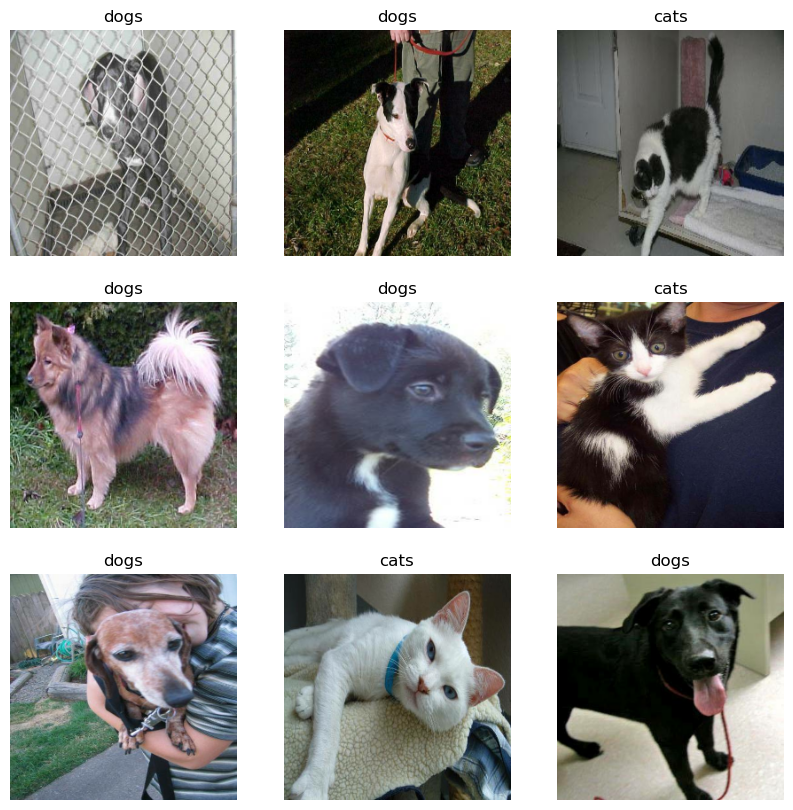

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


(32, 180, 180, 3) above means: `32` images, `180x180` pixes, `3` color channels  
(32,) the label either `0` or `1` for ['cats', 'dogs']

In [11]:
for image_batch, labels_batch in train_ds:
    print(labels_batch)
    break

tf.Tensor([0 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1], shape=(32,), dtype=int32)


#### Standardize The Data

RBG color channels are in [0, 255] range. This is not ideal for a neural network; in general it should be small values, so we will standardize the data values to be between [0, 1]

We will standardize the data when it gets passed into the model as a layer which will make it easier to deploy. This is done when creating the model below.

#### Configure The Dataset For Performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Train A Tensorflow Model

In [13]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255), # this is where we standardize the images to be of values between [0, 1]

    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# model.summary()

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    shuffle=True
)

Epoch 1/10


2024-06-01 10:13:32.261283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-01 10:13:32.282791: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2024-06-01 10:13:32.292601: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


251/251 [==============================] - ETA: 0s - loss: 0.6570 - accuracy: 0.6151

2024-06-01 10:13:42.469838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-06-01 10:13:42.479974: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2024-06-01 10:13:42.484814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


251/251 [==============================] - 12s 44ms/step - loss: 0.6570 - accuracy: 0.6151 - val_loss: 0.6114 - val_accuracy: 0.6823
Epoch 2/10
251/251 [==============================] - 10s 41ms/step - loss: 0.5470 - accuracy: 0.7214 - val_loss: 0.5848 - val_accuracy: 0.6908
Epoch 3/10
251/251 [==============================] - 10s 41ms/step - loss: 0.4630 - accuracy: 0.7730 - val_loss: 0.5259 - val_accuracy: 0.7486
Epoch 4/10
251/251 [==============================] - 10s 41ms/step - loss: 0.3829 - accuracy: 0.8277 - val_loss: 0.5989 - val_accuracy: 0.7401
Epoch 5/10
251/251 [==============================] - 10s 41ms/step - loss: 0.3147 - accuracy: 0.8609 - val_loss: 0.6756 - val_accuracy: 0.7257
Epoch 6/10
251/251 [==============================] - 10s 40ms/step - loss: 0.2387 - accuracy: 0.8995 - val_loss: 0.8724 - val_accuracy: 0.7142
Epoch 7/10
251/251 [==============================] - 10s 41ms/step - loss: 0.1676 - accuracy: 0.9323 - val_loss: 1.0356 - val_accuracy: 0.7202
Epo

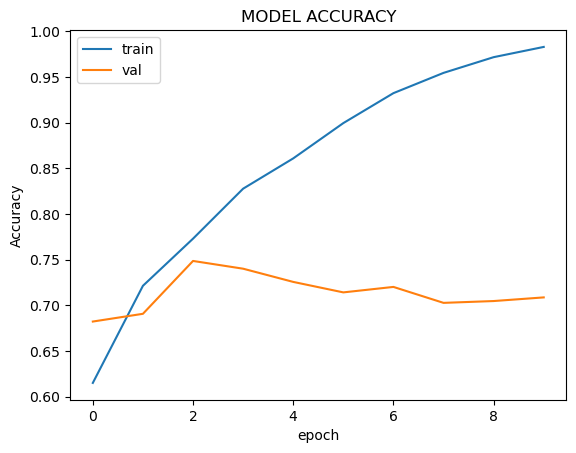

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MODEL ACCURACY')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

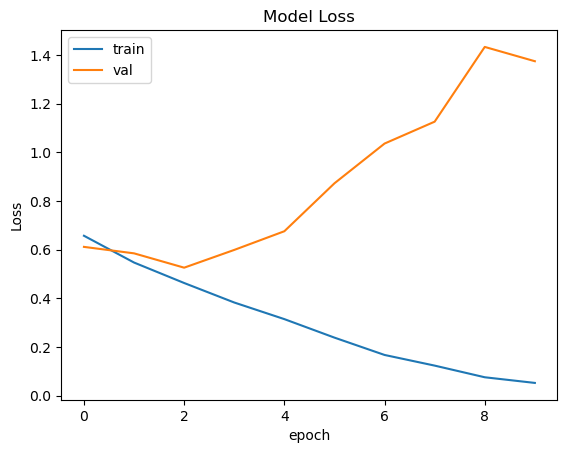

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Pytorch

In [20]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

/Users/tonyavis/miniconda3/envs/AI_env/lib/python3.10/site-packages/transformers/utils/generic.py:462: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Check if pytorch is using GPU, this is on Mac M1 chip

In [21]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


#### Get Image Data

In [22]:
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize(img_adjust_size),  # Resize images to 256x256 pixels
    # Convert images to PyTorch tensors, and also standardize the values to be between [0, 1]
    transforms.ToTensor(),  
    # below line Standardize values to be of values between [-1, 1]
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

# Load the dataset
dataset = datasets.ImageFolder(root=img_dir, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 10028
    Root location: /Users/tonyavis/Main/AI_public_projects/datasets/cat-dog-dataset
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [26]:
dataset.classes

['cats', 'dogs']

In [25]:
num_classes = len(dataset.classes)
num_classes # 0 or 1 cat or dog

2

In [27]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [28]:
for i in train_loader:
    print("Image X input", i[0])
    print("Image Labels", i[1])
    print()
    print("image X shape", i[0].shape)
    print("labels shape",i[1].shape)
    break

Image X input tensor([[[[0.2235, 0.2118, 0.1882,  ..., 0.0157, 0.0157, 0.0157],
          [0.2157, 0.2157, 0.2039,  ..., 0.0157, 0.0157, 0.0157],
          [0.2039, 0.2157, 0.2235,  ..., 0.0157, 0.0157, 0.0157],
          ...,
          [0.0549, 0.0510, 0.0392,  ..., 0.1333, 0.1255, 0.1216],
          [0.0627, 0.0510, 0.0353,  ..., 0.1294, 0.1216, 0.1176],
          [0.0706, 0.0549, 0.0392,  ..., 0.1255, 0.1176, 0.1137]],

         [[0.1765, 0.1647, 0.1412,  ..., 0.0157, 0.0157, 0.0157],
          [0.1686, 0.1686, 0.1569,  ..., 0.0157, 0.0157, 0.0157],
          [0.1569, 0.1725, 0.1765,  ..., 0.0157, 0.0157, 0.0157],
          ...,
          [0.0667, 0.0627, 0.0471,  ..., 0.1176, 0.1098, 0.1059],
          [0.0745, 0.0627, 0.0431,  ..., 0.1176, 0.1098, 0.1059],
          [0.0824, 0.0667, 0.0471,  ..., 0.1137, 0.1059, 0.1020]],

         [[0.0902, 0.0784, 0.0627,  ..., 0.0078, 0.0078, 0.0078],
          [0.0824, 0.0824, 0.0784,  ..., 0.0078, 0.0078, 0.0078],
          [0.0667, 0.0824, 0

#### Visualization

In [29]:
def imshow(img):
    img = img / 2 + 0.5 # un-normalize image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

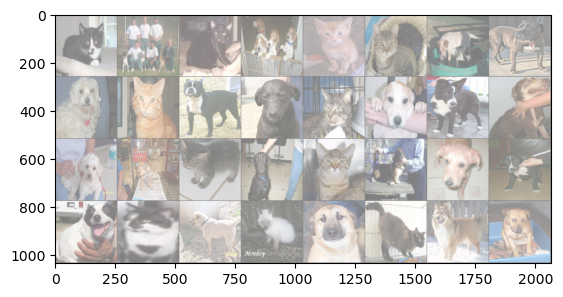

cats  dogs  cats  dogs  cats  cats  dogs  dogs  dogs  cats  dogs  dogs  cats  dogs  dogs  dogs  dogs  dogs  cats  dogs  cats  dogs  dogs  dogs  dogs  cats  dogs  cats  dogs  cats  dogs  dogs 


In [30]:
import torchvision
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{dataset.classes[labels[j]]:5s}' for j in range(batch_size)))

### Pytorch Model

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

In [32]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # u can use the same pooling layer because pooling doesn't have parameters to learn
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        
        self.flatten = nn.Flatten() # 32*32*32 = 32,768 shape after flattening
        
        self.fc1 = nn.Linear(in_features=32768, out_features=128)  # Adjust the size based on the input image size
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        
        # return x
        return F.log_softmax(x, dim=1) # return a softmax outputs are in the range (0, 1) and sum up to 1.


In [33]:
trainingEpoch_loss = []
validationEpoch_loss = []

In [34]:
def train(model, device, train_loader, optimizer, epoch) -> float:
    model.train()
    latest_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device) # move the inputs and labels data to the GPU device
        optimizer.zero_grad()
        output = model(inputs)
        loss = F.nll_loss(output, labels)
        loss.backward()
        optimizer.step()
        latest_loss = loss.item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return latest_loss

In [35]:
def test(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return val_loss

In [36]:
device = torch.device("mps")
cnn_model = CNN(num_classes).to(device) # move model to device

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [37]:
log_interval = 10
for epoch in range(1, num_epochs + 1):
    trainingEpoch_loss.append(train(cnn_model, device=device, train_loader=train_loader, optimizer=optimizer, epoch=epoch))
    validationEpoch_loss.append( test(cnn_model, device=device, val_loader=val_loader))
    scheduler.step()

Train Epoch: 1 [0/8022 (0%)]	Loss: 0.693986
Train Epoch: 1 [320/8022 (4%)]	Loss: 0.697127
Train Epoch: 1 [640/8022 (8%)]	Loss: 0.689326
Train Epoch: 1 [960/8022 (12%)]	Loss: 0.695075
Train Epoch: 1 [1280/8022 (16%)]	Loss: 0.691737
Train Epoch: 1 [1600/8022 (20%)]	Loss: 0.700098
Train Epoch: 1 [1920/8022 (24%)]	Loss: 0.679170
Train Epoch: 1 [2240/8022 (28%)]	Loss: 0.675615
Train Epoch: 1 [2560/8022 (32%)]	Loss: 0.696516
Train Epoch: 1 [2880/8022 (36%)]	Loss: 0.696432
Train Epoch: 1 [3200/8022 (40%)]	Loss: 0.676904
Train Epoch: 1 [3520/8022 (44%)]	Loss: 0.685840
Train Epoch: 1 [3840/8022 (48%)]	Loss: 0.715250
Train Epoch: 1 [4160/8022 (52%)]	Loss: 0.695648
Train Epoch: 1 [4480/8022 (56%)]	Loss: 0.659058
Train Epoch: 1 [4800/8022 (60%)]	Loss: 0.709742
Train Epoch: 1 [5120/8022 (64%)]	Loss: 0.662144
Train Epoch: 1 [5440/8022 (68%)]	Loss: 0.687589
Train Epoch: 1 [5760/8022 (72%)]	Loss: 0.760589
Train Epoch: 1 [6080/8022 (76%)]	Loss: 0.604327
Train Epoch: 1 [6400/8022 (80%)]	Loss: 0.705888
T

In [38]:
trainingEpoch_loss, validationEpoch_loss

([0.6516664028167725,
  0.6138342022895813,
  0.4314922094345093,
  0.34101876616477966,
  0.2579874098300934,
  0.15232254564762115,
  0.2218499630689621,
  0.15924274921417236,
  0.1477697342634201,
  0.03606373444199562],
 [0.6500557417408419,
  0.5871565358588845,
  0.5751432008068202,
  0.5608955756022946,
  0.5930331996525986,
  0.6616090672798195,
  0.7688841111400905,
  0.8546166748016448,
  0.9155138948503306,
  0.9692341280601555])

<function matplotlib.pyplot.show(close=None, block=None)>

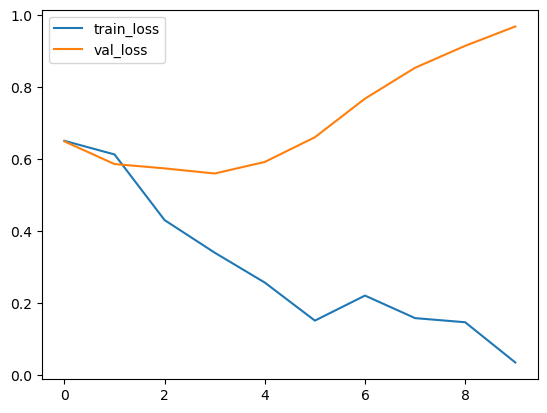

In [39]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

optional save the model

In [ ]:
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)